In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# path = 'gdrive/MyDrive/AML Project Fall 2022/'
# raw_data = pd.read_csv(path + "Data Cleaning/combined_checkpoint.csv")
# pd.set_option('display.max_columns', None)

In [22]:
raw_data = pd.read_csv("combined_checkpoint.csv")
pd.set_option('display.max_columns', None)
joined_data =  pd.read_csv("joined.csv")
profit_data = pd.read_csv("profit_df.csv")

# Initial Data Exploration

In [23]:
# raw_data.info()

In [24]:
raw_data.describe()

,Unnamed: 0,Wk,xG,xG.1,DATE_DAY,DATE_YEAR,1,X,2,Bs,1_PROB,X_PROB,2_PROB
count,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000
mean,4579.276596,18.982539,1.511621,1.241547,15.988321,2019.610777,71.455134,313.997456,321.281337,11.482424,0.455650,0.258855,0.325909
std,2660.909519,10.747113,0.825700,0.754069,8.741814,1.488861,342.133094,141.083377,453.533600,1.883852,0.198045,0.055238,0.181118
min,0.000000,1.000000,0.000000,0.000000,1.000000,2017.000000,-3333.000000,121.000000,-1111.000000,9.000000,0.039401,0.047916,0.022589
25%,2291.750000,10.000000,0.900000,0.700000,8.000000,2018.000000,-145.000000,235.000000,131.000000,10.000000,0.311526,0.230415,0.188679
50%,4572.500000,19.000000,1.400000,1.100000,17.000000,2020.000000,125.000000,265.000000,238.000000,11.000000,0.444444,0.273973,0.295858
75%,6860.250000,28.000000,2.000000,1.700000,23.000000,2021.000000,221.000000,334.000000,430.000000,12.000000,0.591837,0.298507,0.432900
max,9131.000000,38.000000,5.900000,5.700000,31.000000,2022.000000,2438.000000,1987.000000,4327.000000,16.000000,0.970871,0.452489,0.917424


In [25]:
cat_cols = ['COUNTRY','LEAGUE_NAME','Home','Away','Venue','Referee'] 
for i in cat_cols:
    if len(raw_data[i].unique())<10:
        print(f'{i}: {raw_data[i].unique()}')
    else:
        print(f'{i} examples: {raw_data[i].unique()[:10]}')

COUNTRY: ['france' 'spain' 'england' 'germany' 'italy']
LEAGUE_NAME: ['ligue-1' 'laliga' 'premier-league' 'bundesliga' 'serie-a']
Home examples: ['Marseille' 'Nantes' 'Nice' 'Angers' 'Lille' 'St Etienne' 'Montpellier'
 'Lyon' 'Bordeaux' 'Paris SG']
Away examples: ['Toulouse' 'Monaco' 'Reims' 'Nimes' 'Rennes' 'Guingamp' 'Dijon' 'Amiens'
 'Strasbourg' 'Caen']
Venue examples: ['Orange Vélodrome' 'Stade de la Beaujoire - Louis Fonteneau'
 'Stade de Nice' 'Stade Raymond Kopa' 'Stade Pierre-Mauroy'
 'Stade Geoffroy-Guichard' 'Stade de la Mosson' 'Groupama Stadium'
 'Stade Matmut-Atlantique' 'Parc des Princes']
Referee examples: ['Ruddy Buquet' 'Jérôme Brisard' 'Johan Hamel' 'Antony Gautier'
 'Willy Delajod' 'Amaury Delerue' 'Florent Batta' 'Franck Schneider'
 'Hakim Ben El Hadj Salem' 'Benoît Bastien']


In [26]:
# raw_data.isnull().sum()
# no null values

# Preprocessing Functions

In [27]:
use_case_list = ['win','score','xG_diff']

**Season year**

In [28]:
def calc_season(x):
    date_form = datetime.strptime(x, '%Y-%m-%d')
    if date_form < datetime(2018, 8, 1):
        season = 1
    elif date_form < datetime(2019, 8, 1):
        season = 2
    elif date_form < datetime(2020, 8, 1):
        season = 3
    elif date_form < datetime(2021, 8, 1):
        season = 4
    else: 
        season = 5
    return season

**Last N games**

In [29]:
def calc_last_n(x, n=3, use_case='', home='Y', weighted='N', alpha=0.2):
    i = x['index']
    if home=='Y':
        team = x['Home']
    else:
        team = x['Away']
    team_df = df.iloc[:i,:][(df['Home']==team)|(df['Away']==team)].tail(n)
    if weighted == 'N':
        weights = np.ones(n)
    else:
        weights = np.exp((2 * alpha / n) * np.arange(n))
    if len(team_df) == n:
        if use_case == 'win':
            team_df['team_vals'] = team_df.apply(lambda x: x['home_win'] if x['Home']==team else x['home_loss'], axis=1)
            team_vals =  team_df['team_vals'].values
            total = team_vals * weights
            avg = np.sum(total)/np.sum(weights)
        elif use_case == 'score':
            team_df['team_vals'] = team_df.apply(lambda x: x['home_score'] if x['Home']==team else x['away_score'], axis=1)
            team_vals =  team_df['team_vals'].values
            total = team_vals * weights
            avg = np.sum(total)/np.sum(weights)
        elif use_case == 'xG_diff':
            team_df['team_vals'] = team_df.apply(lambda x: x['xG_diff'] if x['Home']==team else -1 * x['xG_diff'], axis=1)
            team_vals =  team_df['team_vals'].values
            total = team_vals * weights
            avg = np.sum(total)/np.sum(weights)
        else:
            print(f"please choose one of the three use cases: 'win', 'score', 'xG_diff' ")
            raise AssertionError
    else:
        avg = np.nan
    return avg

**Cumulative (current season or all seasons)**

In [30]:
def calc_cumulative(x, use_case='', home='Y', current_season='Y', weighted='N'):
    i = x['index']    
    if home=='Y':
        team = x['Home']
    else:
        team = x['Away']    
    
    if current_season == 'Y':
        season = x['season']
        team_df = df.iloc[:i,:][((df['Home']==team)|(df['Away']==team)) & (df['season']==season)]
    else: 
        team_df = df.iloc[:i,:][(df['Home']==team)|(df['Away']==team)]
    
    if weighted == 'N':
        weights = np.ones(len(team_df))
    else:
        weights = np.arrange(1, len(team_df)+1)
    
    if len(team_df)!=0: # team_df is not empty
        if use_case == 'win':
            team_df['team_vals'] = team_df.apply(lambda x: x['home_win'] if x['Home']==team else x['home_loss'], axis=1)
            team_vals =  team_df['team_vals'].values
            total = team_vals * weights 
            avg = np.sum(total)/np.sum(weights)
        elif use_case == 'score':
            team_df['team_vals'] = team_df.apply(lambda x: x['home_score'] if x['Home']==team else x['away_score'], axis=1)
            team_vals =  team_df['team_vals'].values
            total = team_vals * weights
            avg = np.sum(total)/np.sum(weights)  
        elif use_case == 'xG_diff':
            team_df['team_vals'] = team_df.apply(lambda x: x['xG_diff'] if x['Home']==team else -1 * x['xG_diff'], axis=1)
            team_vals =  team_df['team_vals'].values
            total = team_vals * weights
            avg = np.sum(total)/np.sum(weights)
        else:
            print(f"please choose one of the three use cases: 'win', 'score', xG_diff ")
    else: 
        avg = np.nan
    return avg

# Preprocessing Steps

**Create Target variables - we will focus on predicting home_win**

In [31]:
df = raw_data.copy().sort_values(by='Date').reset_index(drop=True).reset_index()

In [32]:
df['home_score'] = df['Score'].apply(lambda x: int(x[0]))

In [33]:
df['away_score'] = df['Score'].apply(lambda x: int(x[-1]))

In [34]:
df['home_win'] = np.where((df['home_score']>df['away_score']),1,0)
df['home_loss'] = np.where((df['home_score']<df['away_score']),1,0)
df['home_draw'] = np.where((df['home_score']==df['away_score']),1,0)

In [35]:
df.head()

,index,Unnamed: 0,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Venue,Referee,Match Report,Datetime,COUNTRY,LEAGUE_NAME,DATE,DATE_DAY,DATE_MONTH,DATE_YEAR,TIME,MATCH_NAME,TABLE_SCORE,Cs,1,X,2,Bs,1_PROB,X_PROB,2_PROB,home_score,away_score,home_win,home_loss,home_draw
0,0,3568,1.0,Fri,2017-08-11,19:45 (14:45),Arsenal,2.5,4–3,1.5,Leicester,Emirates Stadium,Mike Dean,Match Report,2017-08-11,england,premier-league,11 Aug 2017,11,Aug,2017,17:45,Arsenal - Leicester,4:3,"['-204', '+365', '+594']",-204,365,594,10,0.671053,0.215054,0.144092,4,3,1,0,0
1,1,3569,1.0,Sat,2017-08-12,12:30 (07:30),Watford,2.1,3–3,2.6,Liverpool,Vicarage Road Stadium,Anthony Taylor,Match Report,2017-08-12,england,premier-league,12 Aug 2017,12,Aug,2017,10:30,Watford - Liverpool,3:3,"['+547', '+324', '-175']",547,324,-175,10,0.154560,0.235849,0.636364,3,3,0,0,1
2,2,3575,1.0,Sat,2017-08-12,17:30 (12:30),Brighton,0.3,0–2,1.9,Manchester City,The American Express Community Stadium,Michael Oliver,Match Report,2017-08-12,england,premier-league,12 Aug 2017,12,Aug,2017,15:30,Brighton - Manchester City,0:2,"['+988', '+480', '-323']",988,480,-323,10,0.091912,0.172414,0.763593,0,2,0,1,0
3,3,3574,1.0,Sat,2017-08-12,15:00 (10:00),Crystal Palace,1.1,0–3,1.5,Huddersfield,Selhurst Park,Jonathan Moss,Match Report,2017-08-12,england,premier-league,12 Aug 2017,12,Aug,2017,13:00,Crystal Palace - Huddersfield,0:3,"['-125', '+258', '+404']",-125,258,404,10,0.555556,0.279330,0.198413,0,3,0,1,0
4,4,3573,1.0,Sat,2017-08-12,15:00 (10:00),Everton,0.6,1–0,0.4,Stoke,Goodison Park,Niel Swarbrick,Match Report,2017-08-12,england,premier-league,12 Aug 2017,12,Aug,2017,13:00,Everton - Stoke,1:0,"['-128', '+256', '+434']",-128,256,434,10,0.561404,0.280899,0.187266,1,0,1,0,0


In [36]:
def calc_perc(target):
    return round(df[target].sum()/len(df),4)
for i in ['home_win','home_loss','home_draw']:
    print(f'{i}%: {calc_perc(i)}')

home_win%: 0.4328
home_loss%: 0.3152
home_draw%: 0.252


**Odds probability of Alaves in 2017** 

In [37]:
df0 = df.copy()

win=[]
for i,r in df.iterrows():
    if r['home_score'] > r['away_score']:
        win.append(0)
    elif r['home_score'] < r['away_score']:
        win.append(1)
    elif r['home_score'] == r['away_score']:
        win.append(2)
df0['Winner'] = win

df4 = df0.loc[(df0['Home']=='Alaves')|(df0['Away']=='Alaves')]
associated_odd_prob = []
winning = []
for i,r in df4.iterrows():
    if r['Home']=='Alaves':
        associated_odd_prob.append(r['1_PROB'])
        if r['Winner'] == 0:
            winning.append(1)
        else:
            winning.append(0)
    elif r['Away']=='Alaves':
        associated_odd_prob.append(r['2_PROB'])
        if r['Winner'] == 1:
            winning.append(1)
        else:
            winning.append(0)
    
df4['PROB'] = associated_odd_prob
df4['WIN'] = winning

df4 = df4.loc[df4['DATE_YEAR']==2017]
df4 = df4.sort_values(by=['DATE'])
values = df4['PROB'].tolist()
mavg = [values[0]]
alphas = [0.0,0.2,0.6,0.8]
for alpha in alphas:
    for i in range(1,len(values)):
        mavg.append((alpha*values[i])+((1-alpha)*mavg[i-1]))

    df4['MAVG'+str(alpha)] = mavg
    mavg = [values[0]]

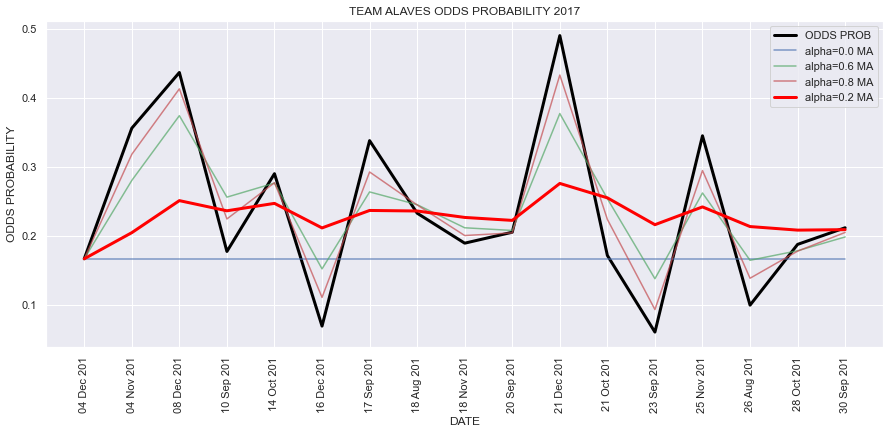

In [38]:
sns.set_theme(style="darkgrid")
sns.set(font_scale=1)
fig,ax = plt.subplots(1,1,figsize=(15,6)) ;
#sns.scatterplot(data=df2,x='DATE',y='PROB',ax=ax,color='black',label='ODDS PROB');
sns.lineplot(data=df4,x='DATE',y='PROB',ax=ax,color='black',linewidth=3,label='ODDS PROB');
for alpha in alphas:
    if alpha==0.2:
        sns.lineplot(data=df4,x='DATE',y='MAVG'+str(alpha),ax=ax,alpha=0.7)
    else:
        sns.lineplot(data=df4,x='DATE',y='MAVG'+str(alpha),ax=ax,alpha=0.7,label='alpha='+str(alpha)+' MA');
#ax.set(ylim=(0,1));
sns.lineplot(data=df4,x='DATE',y='MAVG'+str(0.2),ax=ax,linewidth=3,color='red',label='alpha='+str(0.2)+' MA');
ax.set_ylabel('ODDS PROBABILITY');
ax.set_xticklabels([str(o)[:10] for o in df4['DATE']], rotation=90);
ax.set_title('TEAM ALAVES ODDS PROBABILITY 2017');

**Pairplots** 

In [39]:
df5 = df0[['xG','xG.1','1_PROB','X_PROB','2_PROB','home_score','away_score','Winner']]

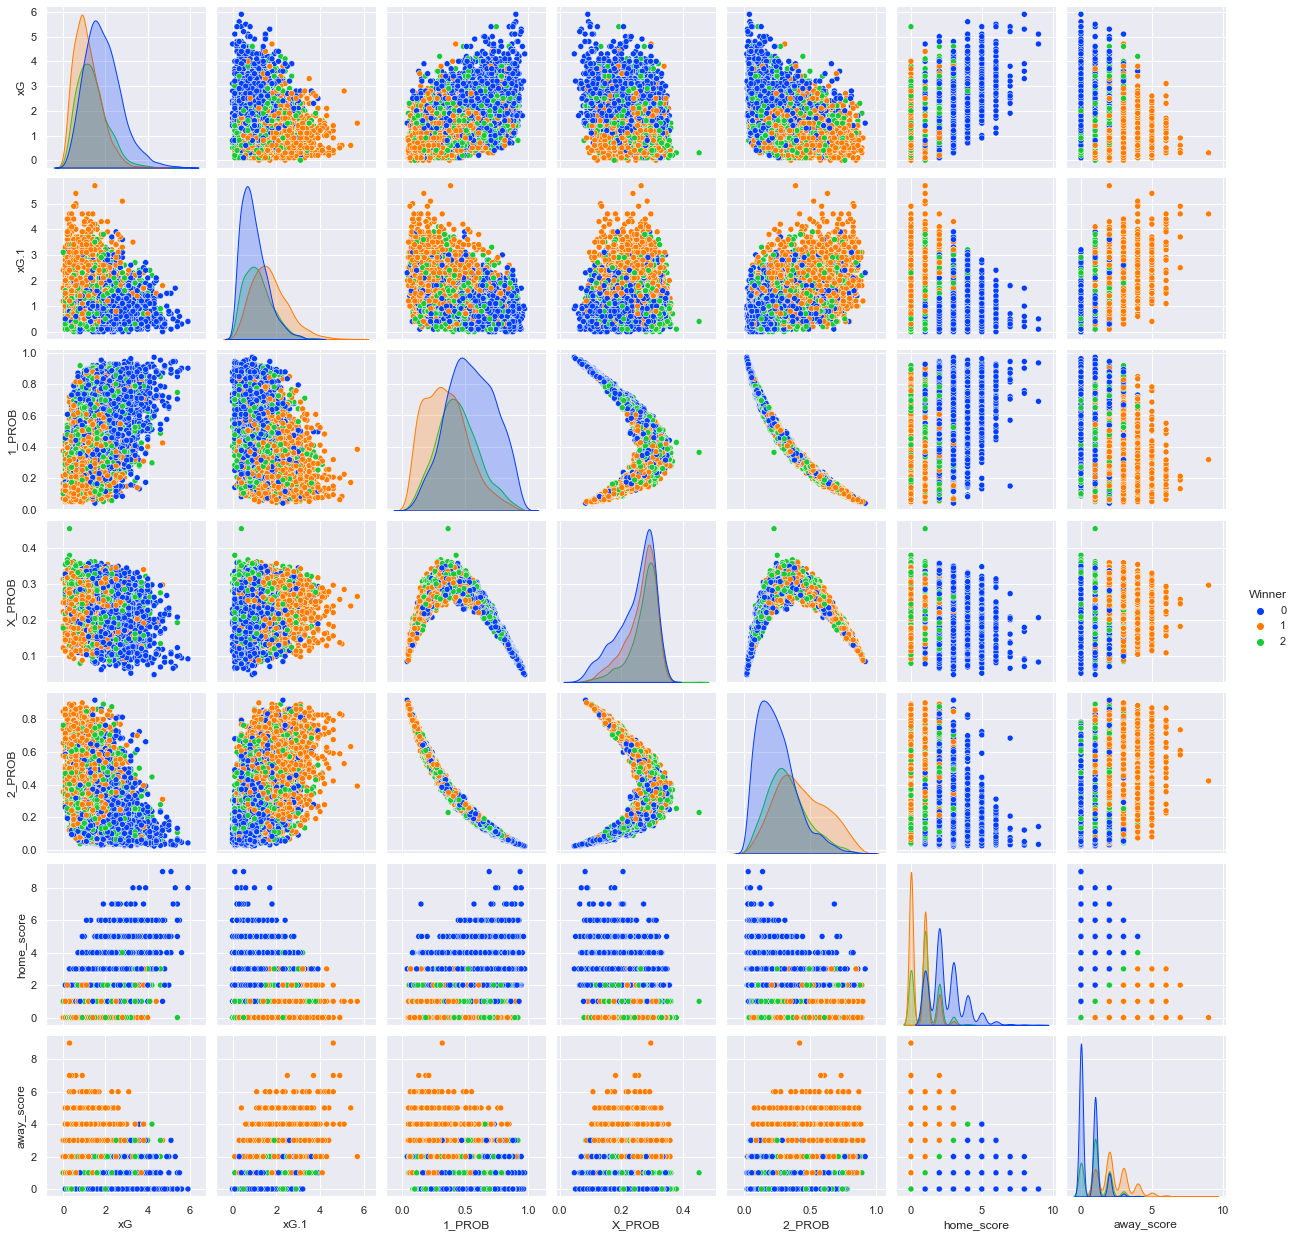

In [40]:
sns.pairplot(df5, hue="Winner",palette="bright")

**Add season year**

In [41]:
df['season']=df['Date'].apply(lambda x: calc_season(x))

**Created xG_diff as difference in home xG and away xG. Then xG_adjusted feature by adjusting xG against the strength of the away team**

In [42]:
df['xG_diff'] = df['xG'] - df['xG.1']

**Create features of last 5 games for both home team and the away team with equal weights and with exponential weights: (1) win%, (2) score, (3) xG_diff**

In [43]:
df['home_last5_avg_win%'] = df.apply(lambda x: calc_last_n(x, n=5, use_case='win'), axis=1)
df['away_last5_avg_win%'] = df.apply(lambda x: calc_last_n(x, n=5, use_case='win', home='N'), axis=1)
df['diff_last5_avg_win%'] = df['home_last5_avg_win%'] - df['away_last5_avg_win%']

In [44]:
df['home_last5_exp_win%'] = df.apply(lambda x: calc_last_n(x, n=5, use_case='win', weighted='Y'), axis=1)
df['away_last5_exp_win%'] = df.apply(lambda x: calc_last_n(x, n=5, use_case='win', home='N', weighted='Y'), axis=1)
df['diff_last5_exp_win%'] = df['home_last5_exp_win%'] - df['away_last5_exp_win%']

In [45]:
df['home_last5_avg_score'] = df.apply(lambda x: calc_last_n(x, n=5, use_case='score'), axis=1)
df['away_last5_avg_score'] = df.apply(lambda x: calc_last_n(x, n=5, use_case='score', home='N'), axis=1)
df['diff_last5_avg_score'] = df['home_last5_avg_score'] - df['away_last5_avg_score']

In [46]:
df['home_last5_exp_score'] = df.apply(lambda x: calc_last_n(x, n=5, use_case='score', weighted='Y'), axis=1)
df['away_last5_exp_score'] = df.apply(lambda x: calc_last_n(x, n=5, use_case='score', home='N', weighted='Y'), axis=1)
df['diff_last5_exp_score'] = df['home_last5_exp_score'] - df['away_last5_exp_score']

In [47]:
df['home_last5_avg_xG_diff'] = df.apply(lambda x: calc_last_n(x, n=5, use_case='xG_diff'), axis=1)
df['away_last5_avg_xG_diff'] = df.apply(lambda x: calc_last_n(x, n=5, use_case='xG_diff', home='N'), axis=1)
df['diff_last5_avg_xG_diff'] = df['home_last5_avg_xG_diff'] - df['away_last5_avg_xG_diff']

In [48]:
df['home_last5_exp_xG_diff'] = df.apply(lambda x: calc_last_n(x, n=5, use_case='xG_diff', weighted='Y'), axis=1)
df['away_last5_exp_xG_diff'] = df.apply(lambda x: calc_last_n(x, n=5, use_case='xG_diff', home='N', weighted='Y'), axis=1)
df['diff_last5_exp_xG_diff'] = df['home_last5_exp_xG_diff'] - df['away_last5_exp_xG_diff']

**Create features of last 8 games for both home team and the away team with equal weights and with exponential weights: (1) win%, (2) score, (3) xG_diff**

In [49]:
df['home_last8_avg_win%'] = df.apply(lambda x: calc_last_n(x, n=8, use_case='win'), axis=1)
df['away_last8_avg_win%'] = df.apply(lambda x: calc_last_n(x, n=8, use_case='win', home='N'), axis=1)
df['diff_last8_avg_win%'] = df['home_last8_avg_win%'] - df['away_last8_avg_win%']

In [50]:
df['home_last8_exp_win%'] = df.apply(lambda x: calc_last_n(x, n=8, use_case='win', weighted='Y'), axis=1)
df['away_last8_exp_win%'] = df.apply(lambda x: calc_last_n(x, n=8, use_case='win', home='N', weighted='Y'), axis=1)
df['diff_last8_exp_win%'] = df['home_last8_exp_win%'] - df['away_last8_exp_win%']

In [51]:
df['home_last8_avg_score'] = df.apply(lambda x: calc_last_n(x, n=8, use_case='score'), axis=1)
df['away_last8_avg_score'] = df.apply(lambda x: calc_last_n(x, n=8, use_case='score', home='N'), axis=1)
df['diff_last8_avg_score'] = df['home_last8_avg_score'] - df['away_last8_avg_score']

In [52]:
df['home_last8_exp_score'] = df.apply(lambda x: calc_last_n(x, n=8, use_case='score', weighted='Y'), axis=1)
df['away_last8_exp_score'] = df.apply(lambda x: calc_last_n(x, n=8, use_case='score', home='N', weighted='Y'), axis=1)
df['diff_last8_exp_score'] = df['home_last8_exp_score'] - df['away_last8_exp_score']

In [53]:
df['home_last8_avg_xG_diff'] = df.apply(lambda x: calc_last_n(x, n=8, use_case='xG_diff'), axis=1)
df['away_last8_avg_xG_diff'] = df.apply(lambda x: calc_last_n(x, n=8, use_case='xG_diff', home='N'), axis=1)
df['diff_last8_avg_xG_diff'] = df['home_last8_avg_xG_diff'] - df['away_last8_avg_xG_diff']

In [54]:
df['home_last8_exp_xG_diff'] = df.apply(lambda x: calc_last_n(x, n=8, use_case='xG_diff', weighted='Y'), axis=1)
df['away_last8_exp_xG_diff'] = df.apply(lambda x: calc_last_n(x, n=8, use_case='xG_diff', home='N', weighted='Y'), axis=1)
df['diff_last8_exp_xG_diff'] = df['home_last8_exp_xG_diff'] - df['away_last8_exp_xG_diff']

**Create features of last 12 games for both home team and the away team with equal weights and with exponential weights: (1) win%, (2) score, (3) xG_diff**

In [55]:
df['home_last12_avg_win%'] = df.apply(lambda x: calc_last_n(x, n=12, use_case='win'), axis=1)
df['away_last12_avg_win%'] = df.apply(lambda x: calc_last_n(x, n=12, use_case='win', home='N'), axis=1)
df['diff_last12_avg_win%'] = df['home_last12_avg_win%'] - df['away_last12_avg_win%']

In [56]:
df['home_last12_exp_win%'] = df.apply(lambda x: calc_last_n(x, n=12, use_case='win', weighted='Y'), axis=1)
df['away_last12_exp_win%'] = df.apply(lambda x: calc_last_n(x, n=12, use_case='win', home='N', weighted='Y'), axis=1)
df['diff_last12_exp_win%'] = df['home_last12_exp_win%'] - df['away_last12_exp_win%']

In [57]:
df['home_last12_avg_score'] = df.apply(lambda x: calc_last_n(x, n=12, use_case='score'), axis=1)
df['away_last12_avg_score'] = df.apply(lambda x: calc_last_n(x, n=12, use_case='score', home='N'), axis=1)
df['diff_last12_avg_score'] = df['home_last12_avg_score'] - df['away_last12_avg_score']

In [58]:
df['home_last12_exp_score'] = df.apply(lambda x: calc_last_n(x, n=12, use_case='score', weighted='Y'), axis=1)
df['away_last12_exp_score'] = df.apply(lambda x: calc_last_n(x, n=12, use_case='score', home='N', weighted='Y'), axis=1)
df['diff_last12_exp_score'] = df['home_last12_exp_score'] - df['away_last12_exp_score']

In [59]:
df['home_last12_avg_xG_diff'] = df.apply(lambda x: calc_last_n(x, n=12, use_case='xG_diff'), axis=1)
df['away_last12_avg_xG_diff'] = df.apply(lambda x: calc_last_n(x, n=12, use_case='xG_diff', home='N'), axis=1)
df['diff_last12_avg_xG_diff'] = df['home_last12_avg_xG_diff'] - df['away_last12_avg_xG_diff']

In [60]:
df['home_last12_exp_xG_diff'] = df.apply(lambda x: calc_last_n(x, n=12, use_case='xG_diff', weighted='Y'), axis=1)
df['away_last12_exp_xG_diff'] = df.apply(lambda x: calc_last_n(x, n=12, use_case='xG_diff', home='N', weighted='Y'), axis=1)
df['diff_last12_exp_xG_diff'] = df['home_last12_exp_xG_diff'] - df['away_last12_exp_xG_diff']

**Create features for the cumulative average (1) win%, (2) score, (3) xG of both Home team and Away team in the current season before this game** 

In [61]:
df['home_cumulative_season_win%'] = df.apply(lambda x: calc_cumulative(x,use_case='win'), axis=1)
df['away_cumulative_season_win%'] = df.apply(lambda x: calc_cumulative(x, home='N',use_case='win'), axis=1)
df['diff_cumulative_season_win%'] = df['home_cumulative_season_win%'] - df['away_cumulative_season_win%']

In [62]:
df['home_cumulative_season_avg_score'] = df.apply(lambda x: calc_cumulative(x,use_case='score'), axis=1)
df['away_cumulative_season_avg_score'] = df.apply(lambda x: calc_cumulative(x,home='N',use_case='score'), axis=1)
df['diff_cumulative_season_avg_score'] = df['home_cumulative_season_avg_score'] - df['away_cumulative_season_avg_score']

In [63]:
df['home_cumulative_season_xG_diff'] = df.apply(lambda x: calc_cumulative(x,use_case='xG_diff'), axis=1)
df['away_cumulative_season_xG_diff'] = df.apply(lambda x: calc_cumulative(x, home='N',use_case='xG_diff'), axis=1)
df['diff_cumulative_season_xG_diff'] = df['home_cumulative_season_xG_diff'] - df['away_cumulative_season_xG_diff']

**Create features for the cumulative average (1) win%, (2) score, (3) xG of both Home team and Away team since 2017 Aug before this game** 

In [64]:
df['home_cumulative_all_win%'] = df.apply(lambda x: calc_cumulative(x, use_case='win', current_season='N'), axis=1)
df['away_cumulative_all_win%'] = df.apply(lambda x: calc_cumulative(x, use_case='win', home='N', current_season='N'), axis=1)
df['diff_cumulative_all_win%'] = df['home_cumulative_all_win%'] - df['away_cumulative_all_win%']

In [65]:
df['home_cumulative_all_avg_score'] = df.apply(lambda x: calc_cumulative(x, use_case='score', current_season='N'), axis=1)
df['away_cumulative_all_avg_score'] = df.apply(lambda x: calc_cumulative(x, use_case='score', current_season='N', home='N'), axis=1)
df['diff_cumulative_all_avg_score'] = df['home_cumulative_all_avg_score'] - df['away_cumulative_all_avg_score']

In [66]:
df['home_cumulative_all_avg_xG_diff'] = df.apply(lambda x: calc_cumulative(x, use_case='xG_diff', current_season='N'), axis=1)
df['away_cumulative_all_avg_xG_diff'] = df.apply(lambda x: calc_cumulative(x, use_case='xG_diff', current_season='N', home='N'), axis=1)
df['diff_cumulative_all_avg_xG_diff'] = df['home_cumulative_all_avg_xG_diff'] - df['away_cumulative_all_avg_xG_diff']

**Basic stats**

In [67]:
df2 = df.copy()
df2 = df2.drop(columns=['index', 'Unnamed: 0', 'Wk', 'Day', 'Date', 'Time', 'Home', 'xG','Score', 'xG.1', 'Away', 
                        'Venue', 'Referee', 'Match Report', 'Datetime','COUNTRY', 'LEAGUE_NAME', 
                        'DATE', 'DATE_DAY', 'DATE_MONTH', 'DATE_YEAR', 'TIME', 'MATCH_NAME', 'TABLE_SCORE', 
                        'Cs', '1', 'X', '2', 'Bs','home_score', 'away_score','home_loss', 'home_draw','xG_diff'],axis=1)
# Referee, Venue: not analyzed - 1) too many categories; 2) commonly not associated with match result so potentially just noises
# COUNTRY, LEAGUE_NAME - Not much info from the analysis below:
# df.groupby(by=['COUNTRY'])['home_win'].agg(['mean','std'])
# df.groupby(by=['LEAGUE_NAME'])['home_win'].agg(['mean','std'])

In [68]:
df2_basicstats_0 = df2[df2['home_win']==0].describe().loc[['mean','std']].transpose().rename(columns=({'mean':'class0_mean','std':'class0_std'}))
df2_basicstats_1 = df2[df2['home_win']==1].describe().loc[['mean','std']].transpose().rename(columns=({'mean':'class1_mean','std':'class1_std'}))
# df2_basicstats_0.join(df2_basicstats_1)

**Correlation matrix** 

In [69]:
def plot_corr(dataframe):
  fig, ax = plt.subplots(figsize=(50, 20))
  x_corr = dataframe.corr()
  mask = np.zeros_like(x_corr, dtype=bool)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(x_corr, mask=mask, xticklabels=x_corr.columns, yticklabels=x_corr.columns, annot=True)
  plt.show()

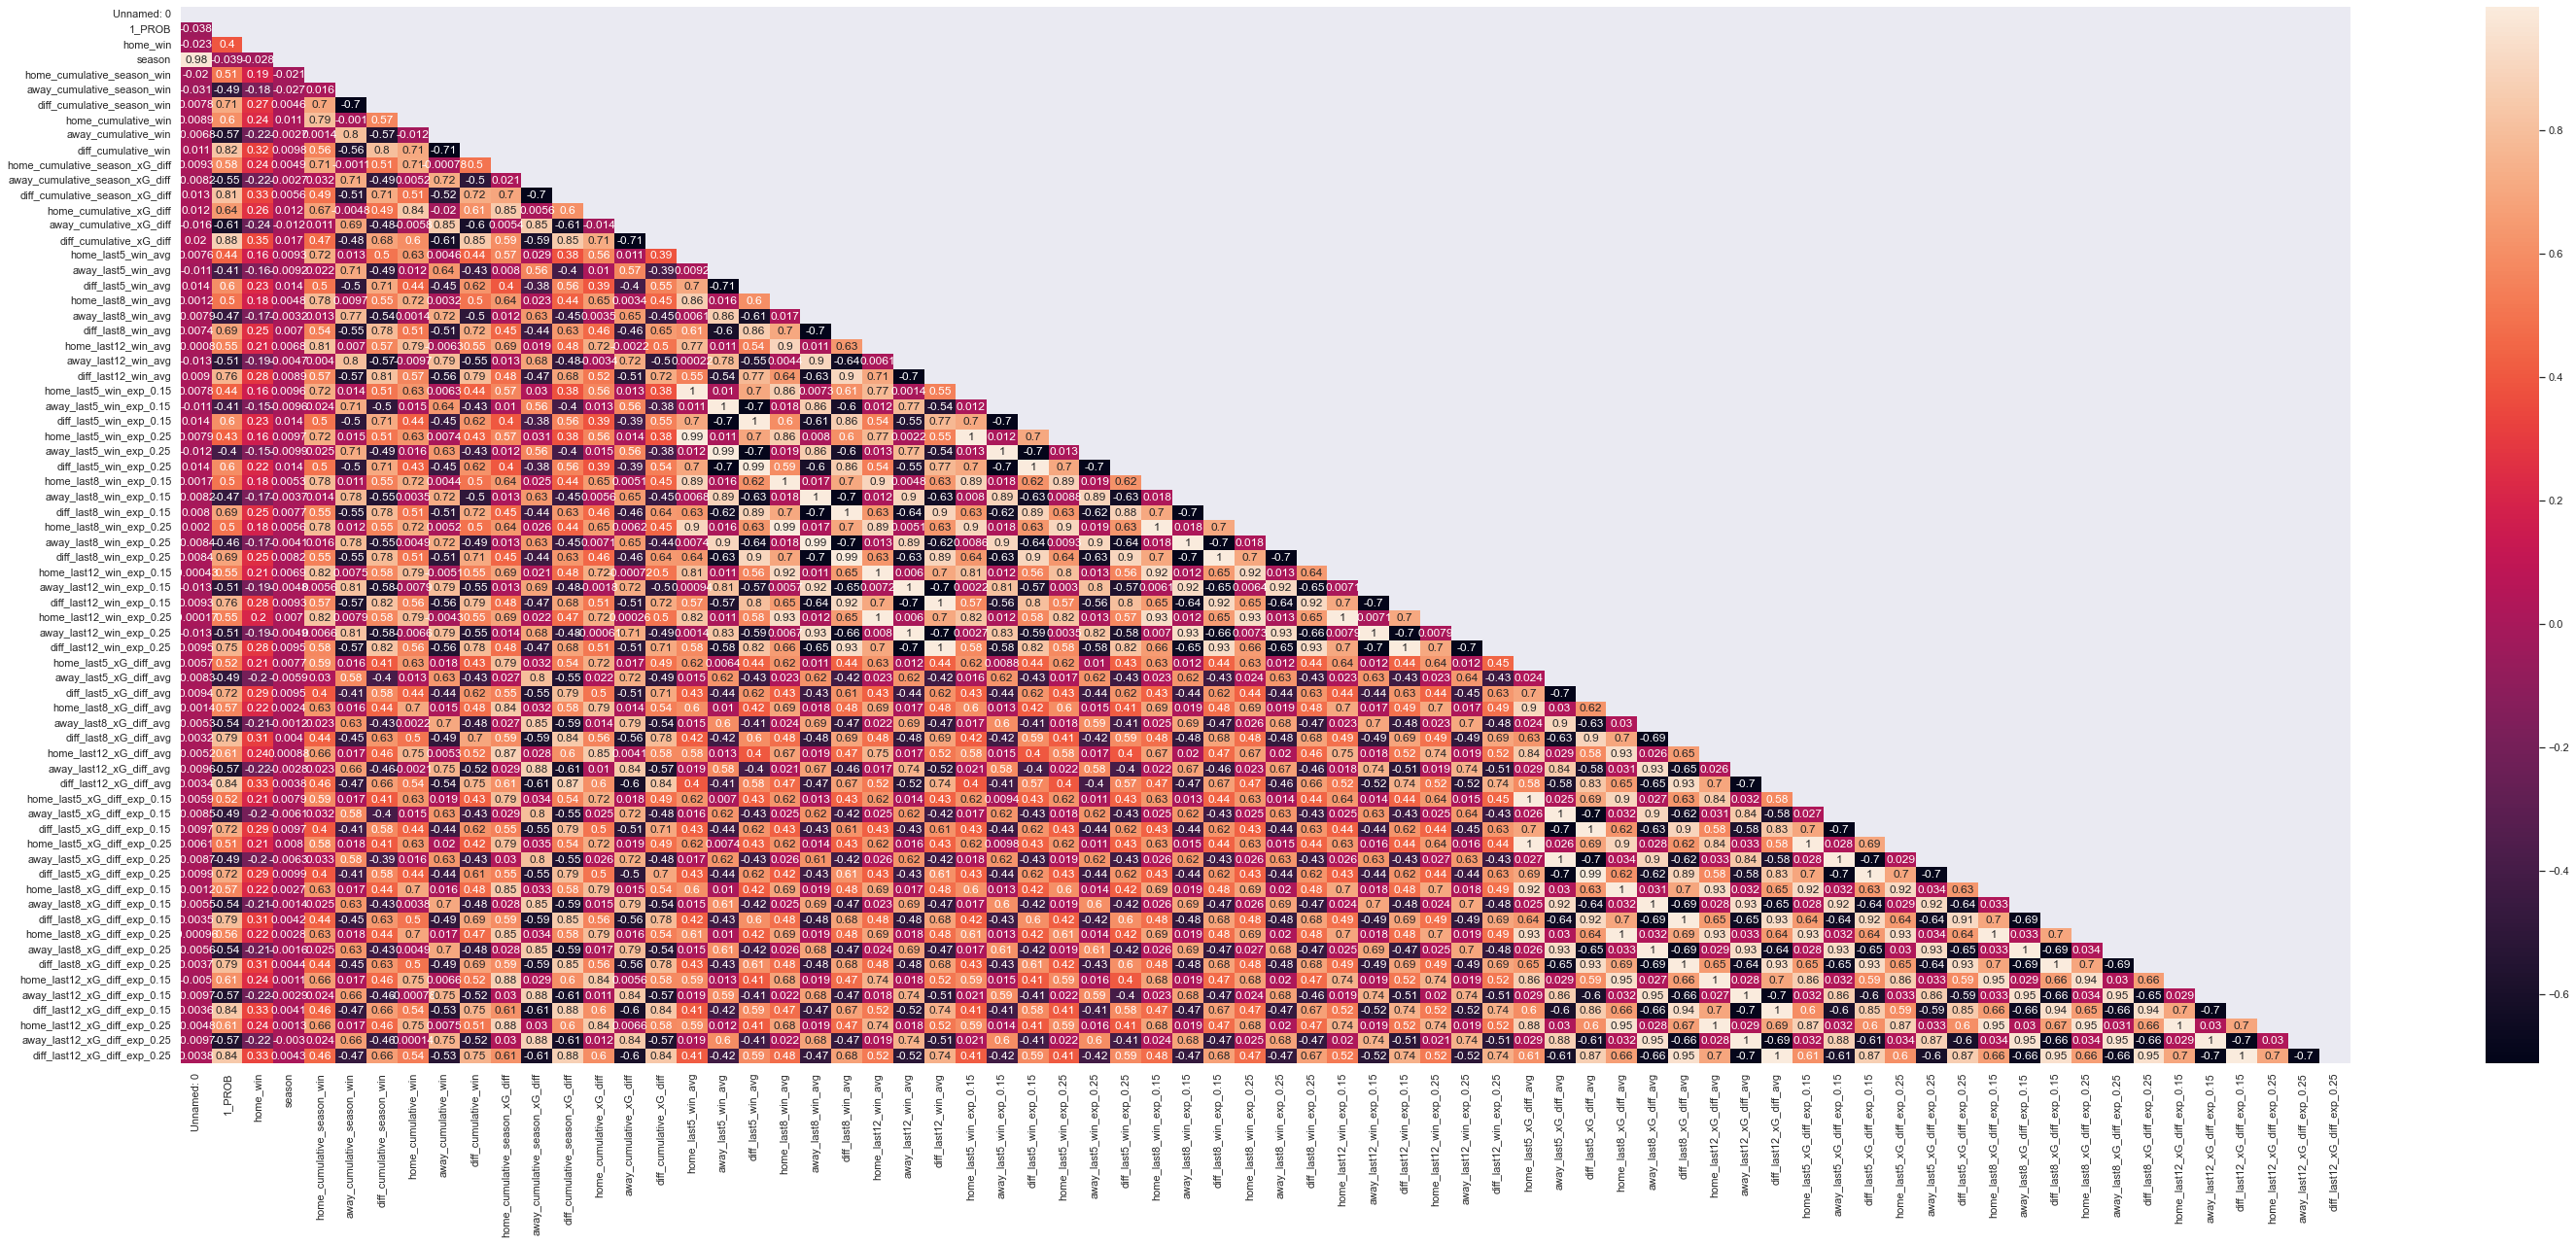

In [70]:
plot_corr(joined_data)

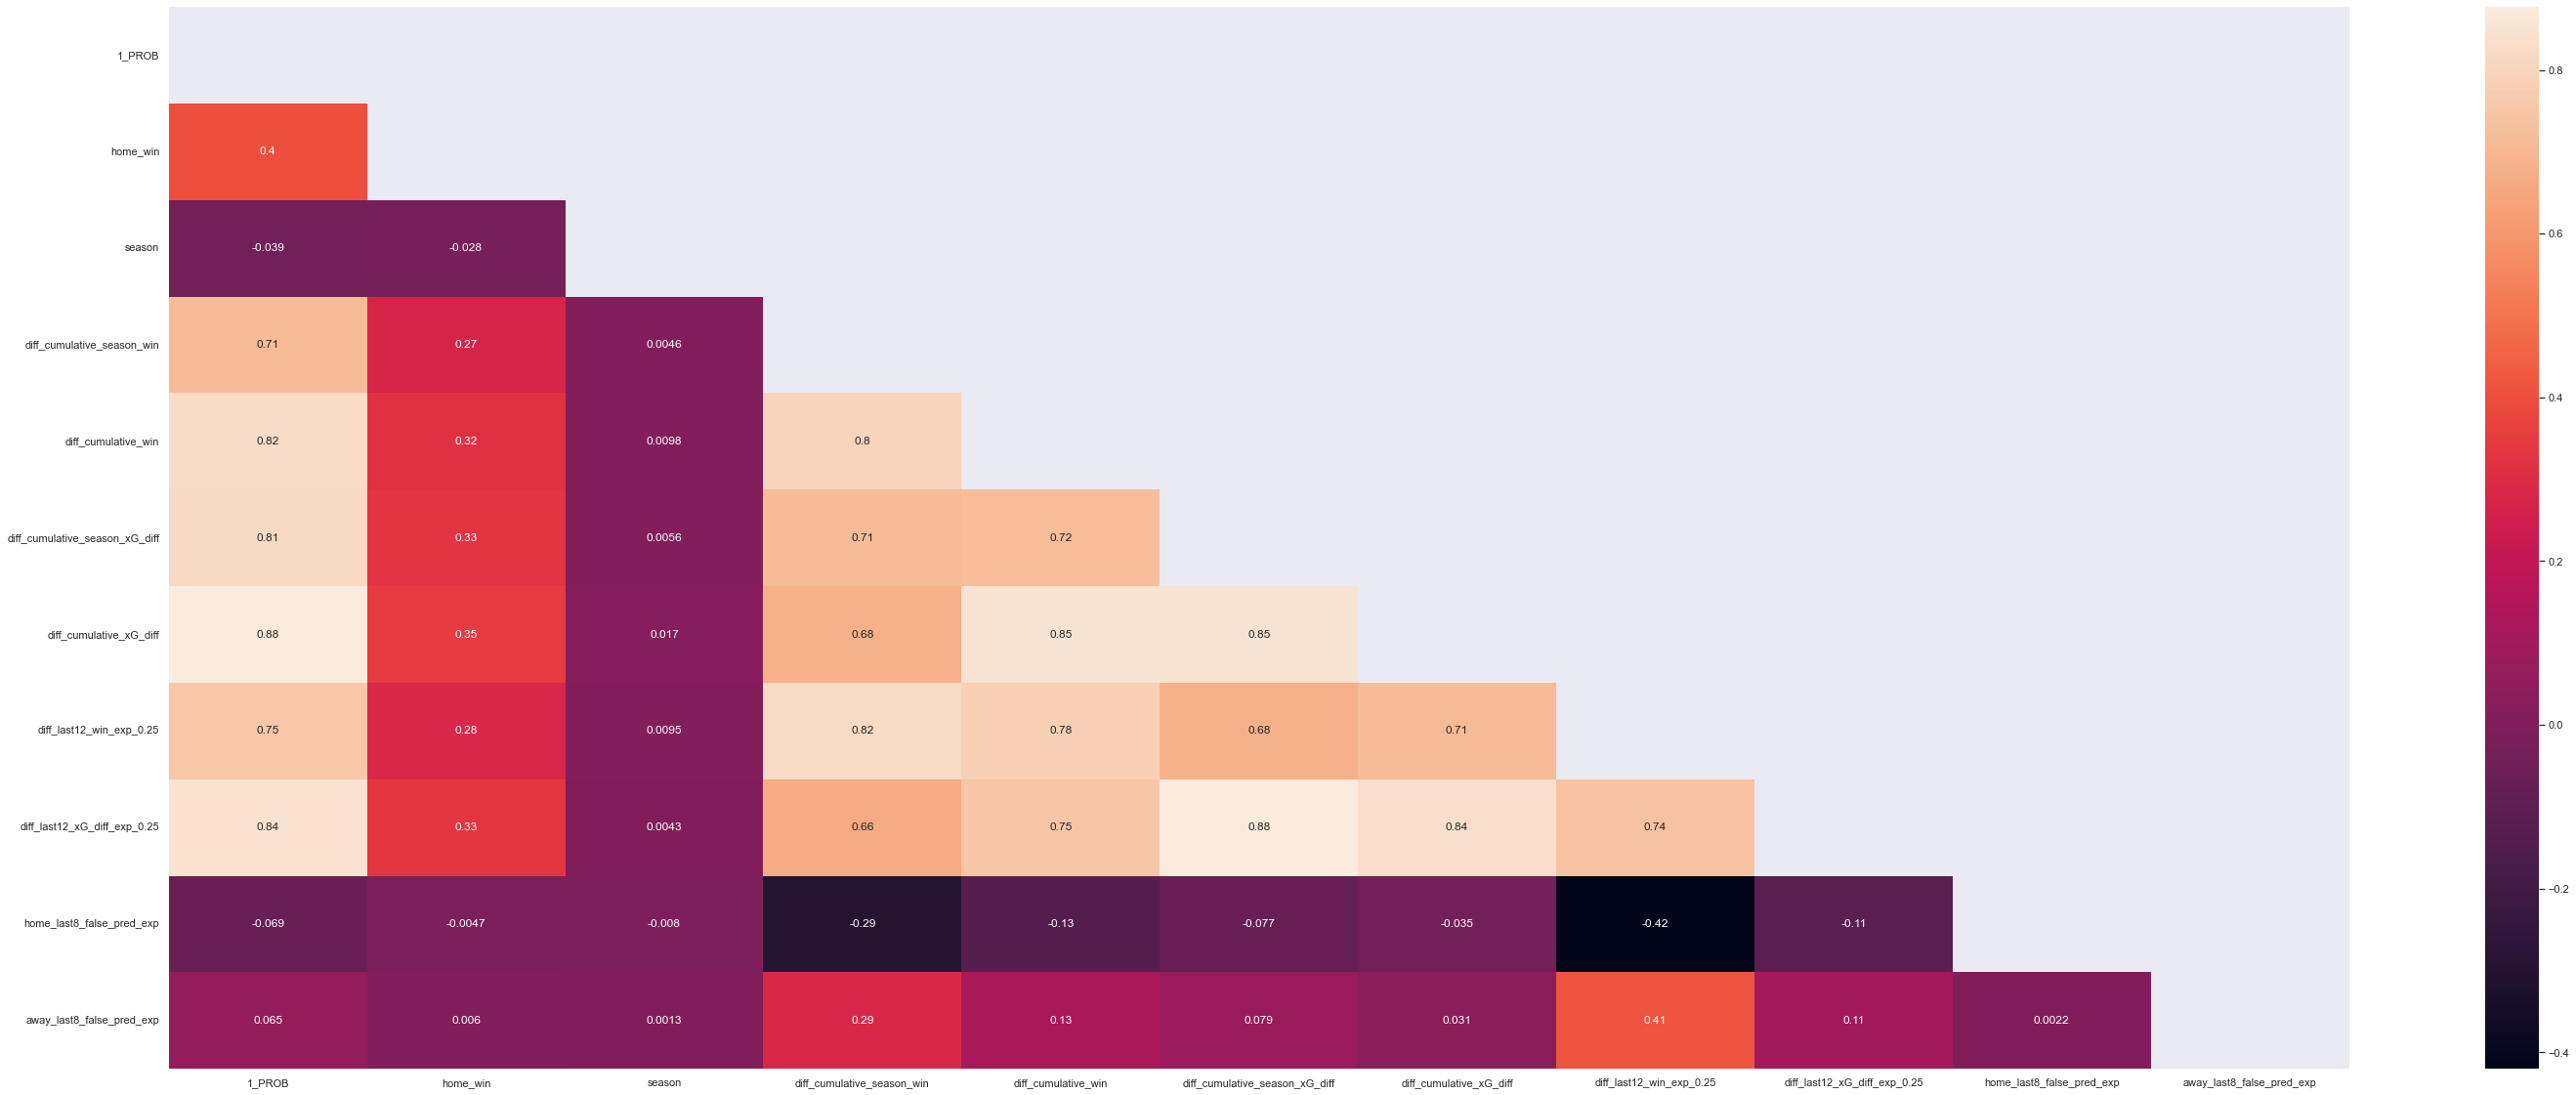

In [71]:
plot_corr(profit_data)

In [72]:
df2.corr()['home_win'].sort_values(ascending=False)[:20]
# the difference metrics are more correlated with home_win
# 1_PROB and xG_diff features are stronger 

home_win                            1.000000
1_PROB                              0.395763
diff_cumulative_all_avg_xG_diff     0.349081
diff_last12_exp_xG_diff             0.333940
diff_last12_avg_xG_diff             0.333377
diff_cumulative_season_xG_diff      0.327981
diff_cumulative_all_win%            0.318606
diff_cumulative_all_avg_score       0.317238
diff_last8_exp_xG_diff              0.309816
diff_last8_avg_xG_diff              0.308069
diff_last5_avg_xG_diff              0.293831
diff_last5_exp_xG_diff              0.293494
diff_last12_avg_win%                0.281066
diff_last12_exp_win%                0.279720
diff_last12_avg_score               0.279354
diff_last12_exp_score               0.278475
diff_cumulative_season_avg_score    0.270405
diff_cumulative_season_win%         0.269609
home_cumulative_all_avg_xG_diff     0.259270
diff_last8_avg_score                0.253940
Name: home_win, dtype: float64

Correlation matrix for subsets of columns

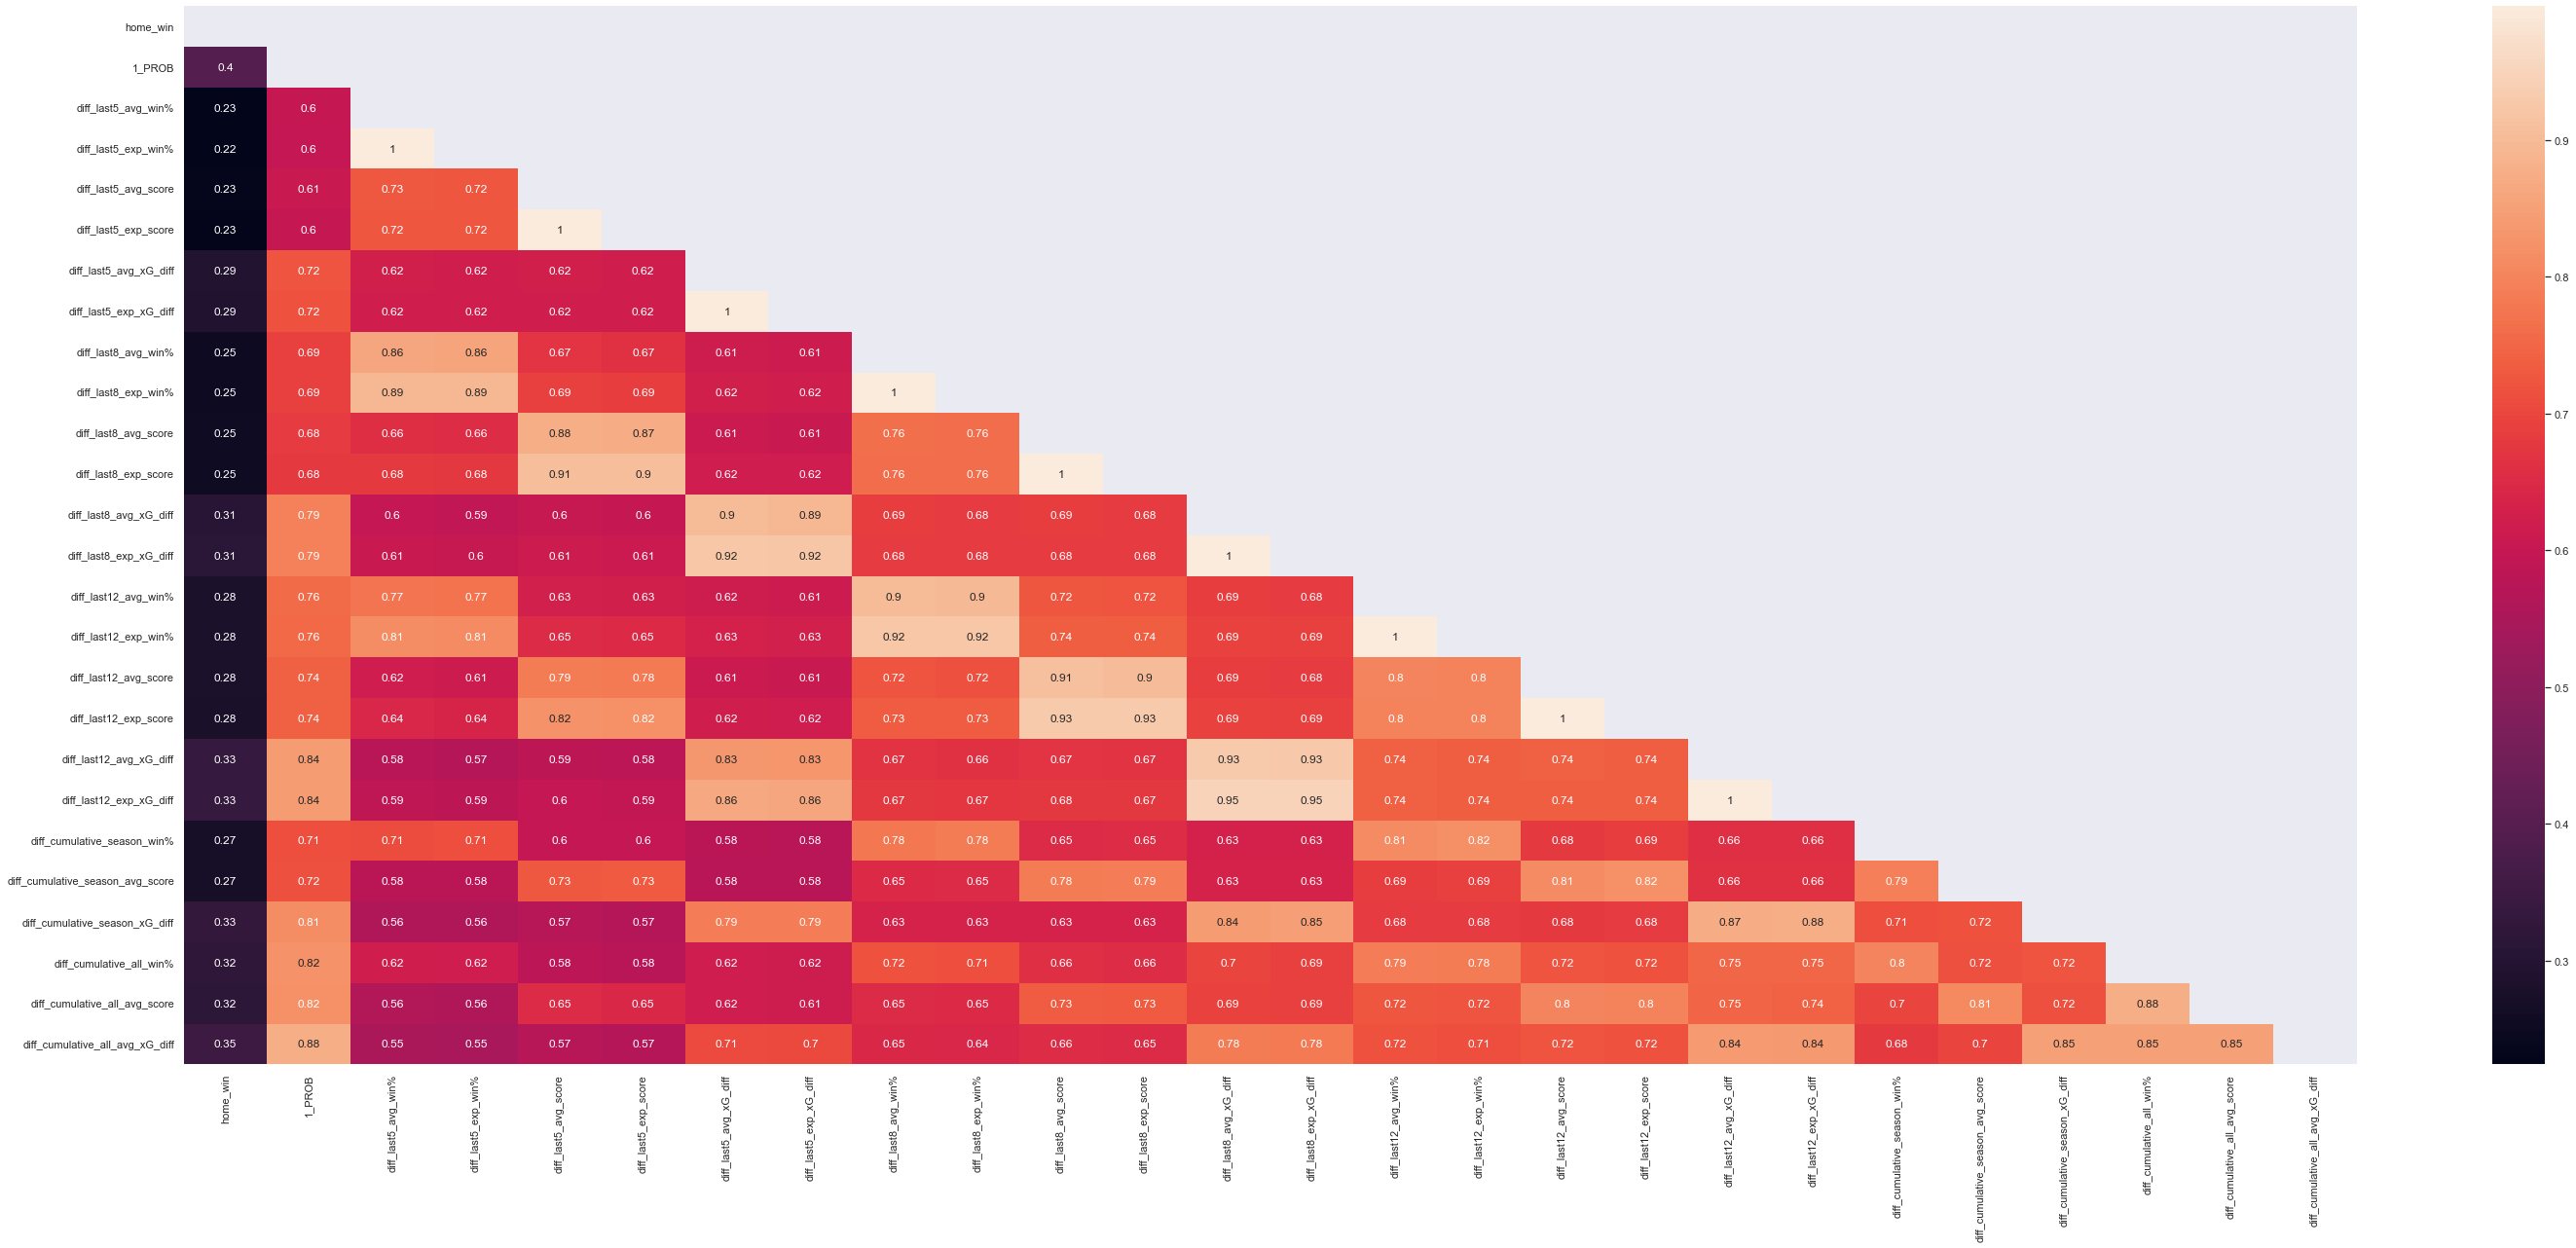

In [73]:
df3 = df2.copy()
df3 = df3[['home_win','1_PROB',
           'diff_last5_avg_win%','diff_last5_exp_win%','diff_last5_avg_score','diff_last5_exp_score','diff_last5_avg_xG_diff','diff_last5_exp_xG_diff',
           'diff_last8_avg_win%','diff_last8_exp_win%','diff_last8_avg_score','diff_last8_exp_score','diff_last8_avg_xG_diff','diff_last8_exp_xG_diff',
           'diff_last12_avg_win%','diff_last12_exp_win%','diff_last12_avg_score','diff_last12_exp_score','diff_last12_avg_xG_diff','diff_last12_exp_xG_diff',
           'diff_cumulative_season_win%','diff_cumulative_season_avg_score','diff_cumulative_season_xG_diff',
           'diff_cumulative_all_win%', 'diff_cumulative_all_avg_score','diff_cumulative_all_avg_xG_diff']]
plot_corr(df3)
# Multicollinearity between features

**histogram plots** 

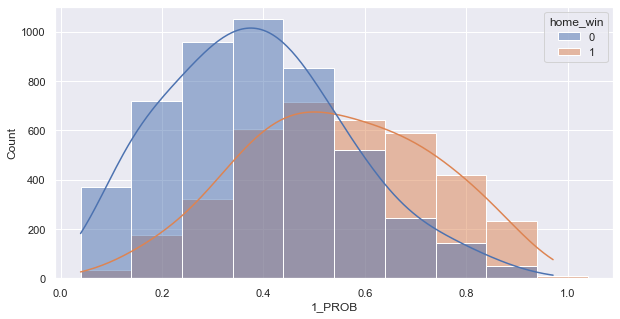

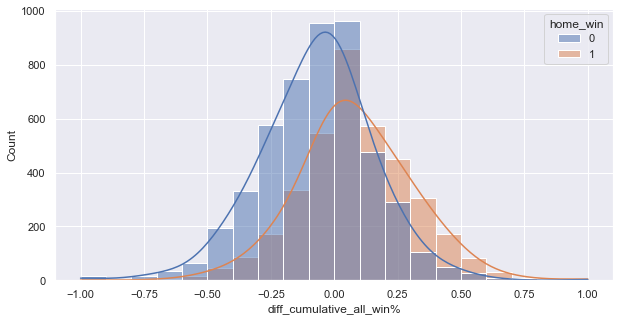

In [74]:
for col in ['1_PROB','diff_cumulative_all_win%']:
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(data=df2, hue='home_win', x=col, kde=True, binwidth=0.1, kde_kws={'bw_adjust':2})
    plt.show()

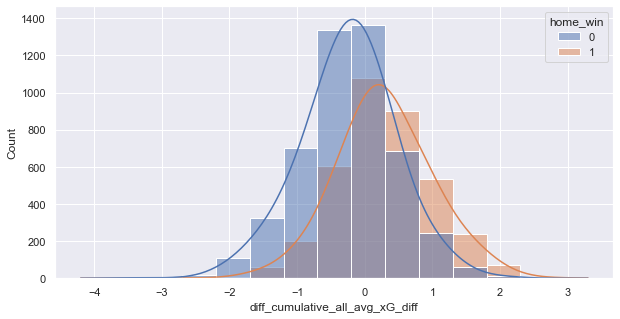

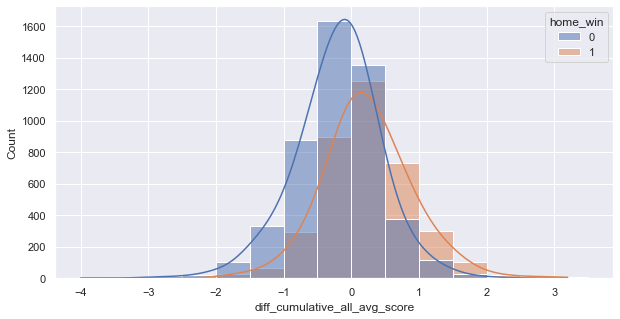

In [75]:
for col in ['diff_cumulative_all_avg_xG_diff','diff_cumulative_all_avg_score']:
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(data=df2, hue='home_win', x=col, kde=True, binwidth=0.5, kde_kws={'bw_adjust':2})
    plt.show()